In [1]:
import sys
sys.path.append("./source")

# libraries for this project
from lmmNet import *
import harmonic
import train_onestep
import predict_onestep
import predict_lmmNet

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# 1. Data Preparation

Here we test our methods on the 2-D Cubic Harmonic Oscillator

$$ \begin{array}
\dot{x_1} & = & -0.1 x_1^3 + 2.0 x_2^3 \\
\dot{x_2} & = & -2.0 x_1^3 - 0.1 x_2^3 \\
\end{array} $$

with the initial conditions $x_1(0) = 2, x_2(0) = 0$. We will use three different approaches:
1. LmmNet
2. One-step machine learning method
3. Recurrent approach

We will also investigate how the method performs under noisy conditions.

In [2]:
time_points, cubic_data = harmonic.simulate_default()

Text(0.5, 1.0, 'Phase Portrait of the 2-D Harmonic Oscillator')

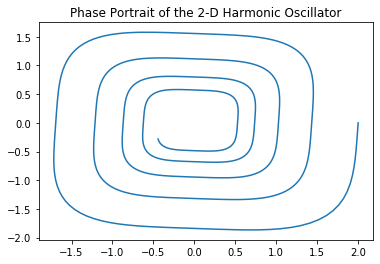

In [3]:
# Phase plane plot
plt.plot(cubic_data[0,:,0], cubic_data[0,:,1])
plt.title('Phase Portrait of the 2-D Harmonic Oscillator')

Now that we have simulated a dataset, let's create a suitable training data and augment it for learning.

# 2. LmmNet

Next, we train the LmmNet on the tensor data.

In [5]:
# we specify a LMM scheme and number of steps
dt = time_points[1] - time_points[0]
M = 1
scheme = 'AM'
model = lmmNet(dt, cubic_data, M, scheme, hidden_units=256)

N_Iter = 10000
model.train(N_Iter, debug=False)

In [7]:
import predict_lmmNet

x0 = cubic_data[0,0,:] # initial conditions
predicted_traj = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), x0, time_points)

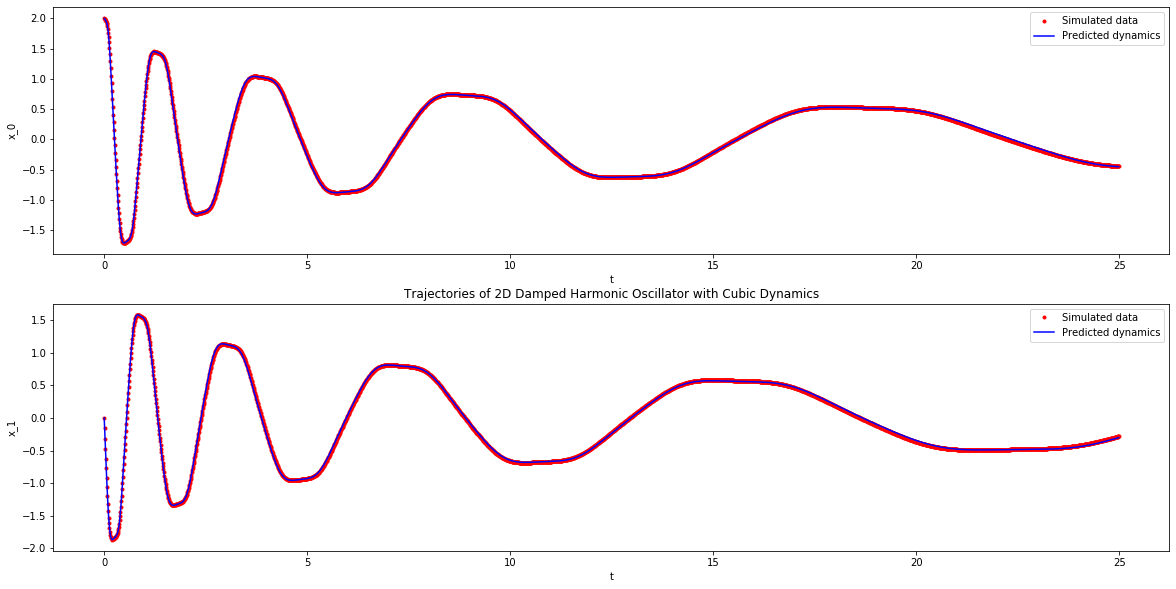

In [10]:
# plot the time-course of the predicted trajectory

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, cubic_data[0,:, species], 'r.', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'b-', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Damped Harmonic Oscillator with Cubic Dynamics')
plt.show()

Text(0.5, 1.0, 'Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

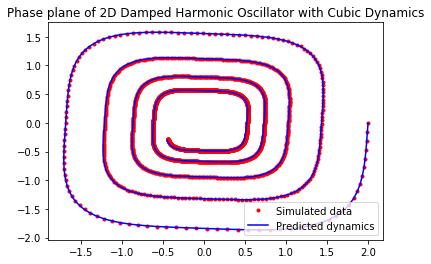

In [11]:
# Phase plane

plt.plot(cubic_data[0,:,0], cubic_data[0,:,1], 'r.', label='Simulated data')
plt.legend()
plt.plot(predicted_traj[:,0], predicted_traj[:,1], 'b-', label='Predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

# 3. One-step machine learning method

Workflow:
* create and augment training data
* fit model with pairs of derivatives and time-series measurements as features
* make predictions and simulations by numerical integration of the learned model

In [4]:
# function to prepare data for training one-step method

def create_data(cubic_data):
    df = pd.DataFrame(cubic_data.numpy()[0])
    df.columns = ['x_component', 'y_component']
    df['Strain'] = [0] * df.shape[0]
    df = df.set_index('Strain')
    df['Time'] = time_points
    print('Original data shape:', df.shape)
    return df

,x_component,y_component,Time
Strain,,,
0,2.000000,0.000000,0.00
0,1.992028,-0.159044,0.01
0,1.983873,-0.316164,0.02
0,1.974847,-0.471225,0.03
0,1.963856,-0.623866,0.04


In [5]:
# now generate and augment the training dataset
df = create_data(cubic_data)
feature_list = [] # here we do not have external time-series or control variables
target_list = ['x_component', 'y_component']

df_train = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=2500)
display(df_train)

Original data shape: (2500, 3)


feature      target     feature      target
             x_component x_component y_component y_component
Strain Time                                                 
0      0.00     1.998828   -0.573398    0.000471  -15.997040
       0.01     1.993096   -0.684085   -0.159436  -15.865381
       0.02     1.985152   -0.905458   -0.316710  -15.602062
       0.03     1.974995   -1.059658   -0.471352  -15.371268
       0.04     1.963967   -1.274520   -0.624012  -15.117056
...                  ...         ...         ...         ...
       24.95   -0.441769   -0.039289   -0.288236    0.174894
       24.96   -0.442157   -0.038403   -0.286486    0.175301
       24.97   -0.442537   -0.037522   -0.284731    0.175704
       24.98   -0.442907   -0.036636   -0.282973    0.176112
       24.99   -0.443269   -0.036193   -0.281210    0.176315

[2500 rows x 4 columns]

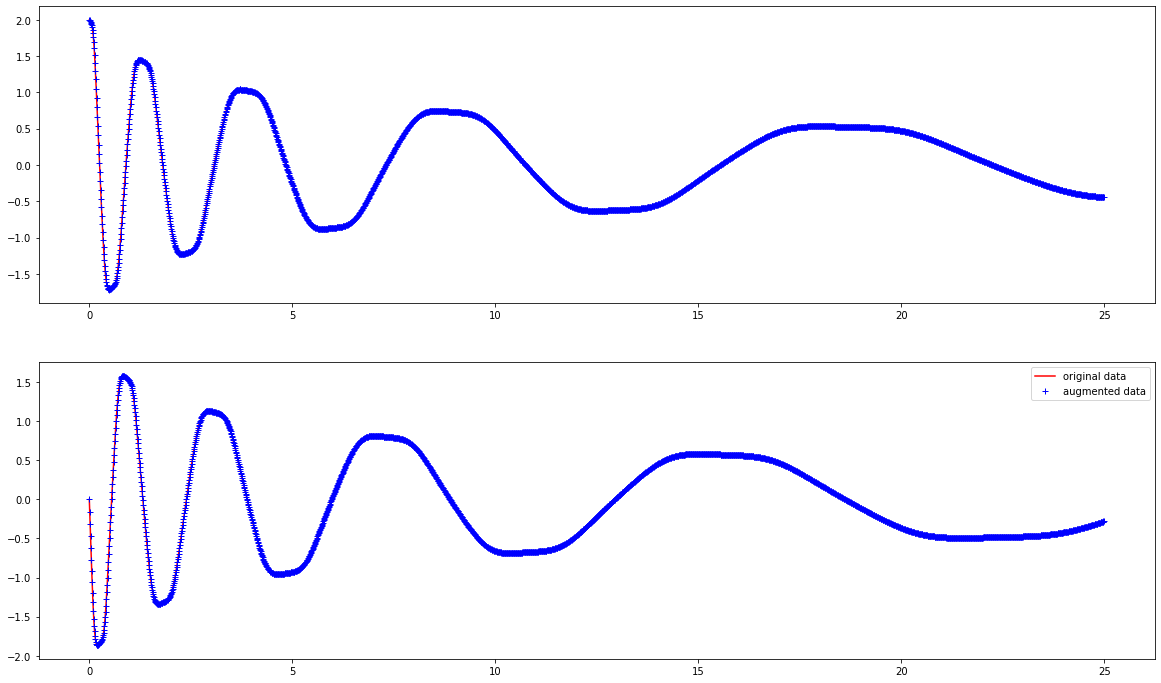

In [9]:
# make sure the augmented data corresponds to the original data
plt.figure(figsize = (20, 12))
for species in range(2):
    plt.subplot(2, 1, species + 1)
    plt.plot(time_points, df.iloc[:,species], 'r-', label='original data')
    plt.plot(time_points, df_train[('feature', df.columns[species])], 'b+', label='augmented data')
    
plt.legend()

x_component


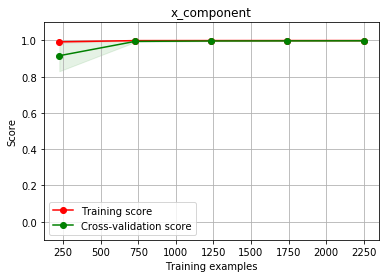

Target: x_component, CV Pearson R2 coefficient: 0.999746
y_component


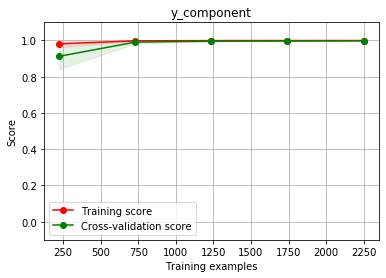

Target: y_component, CV Pearson R2 coefficient: 0.999729
Average training score: 0.9997373867436434


In [6]:
# create a random forest model with 20 estimators
rf_model = RandomForestRegressor(n_estimators=20)
figure_path = './plots/'

# train a model
rf_dict, score_dict = train_onestep.train_classic(df_train, rf_model, plot=True,model_type='random_forest', figure_path=figure_path)

x_component RMSE: -0.0003203681669869832 standard deviation: 0.02837230472528236


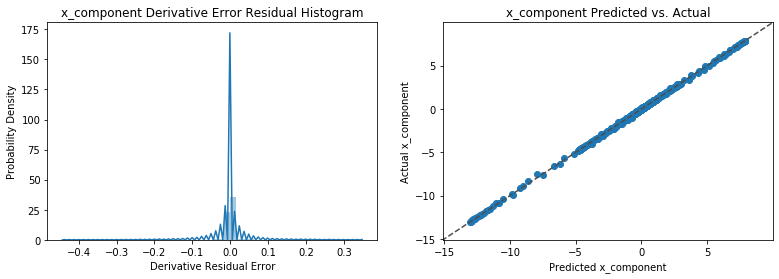

y_component RMSE: -0.000559861653220513 standard deviation: 0.02976401879218204


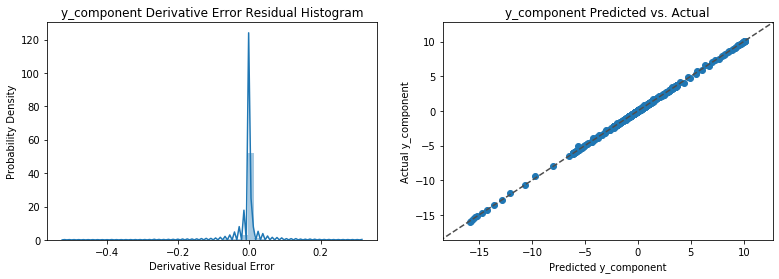

Total Derivative Mean Error: 0.04522540835125016 Error Standard Deviation: 0.07526063461831321


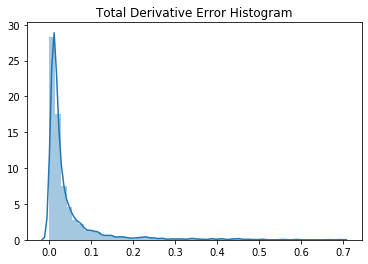

In [7]:
# generate reports on the residual errors

train_onestep.compute_error(df_train,rf_dict,plot=True,model_type='random_forest')

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.992028,-0.159044
0,1.983873,-0.316164
0,1.974847,-0.471225
0,1.963856,-0.623866
...,...,...
0,-0.441769,-0.288236
0,-0.442157,-0.286486
0,-0.442536,-0.284731


Predicted data:


,x_component,y_component
Time,,
0.00,2.000000,0.000000
0.01,1.994155,-0.158144
0.02,1.987850,-0.315643
0.03,1.981915,-0.471115
0.04,1.974474,-0.625047
...,...,...
24.95,0.422254,0.105415
24.96,0.422077,0.103713
24.97,0.421899,0.102011


./source/predict_onestep.py:216: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:221: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 5.1339041470254605 RMSE percentage: 229.5245824728029
ML Fit: y_component 5.202885829509275 RMSE percentage: 184.510708706395
ML model aggregate error
Average RMSE: 5.168394988267368
Total percentage error: 207.01764558959894


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


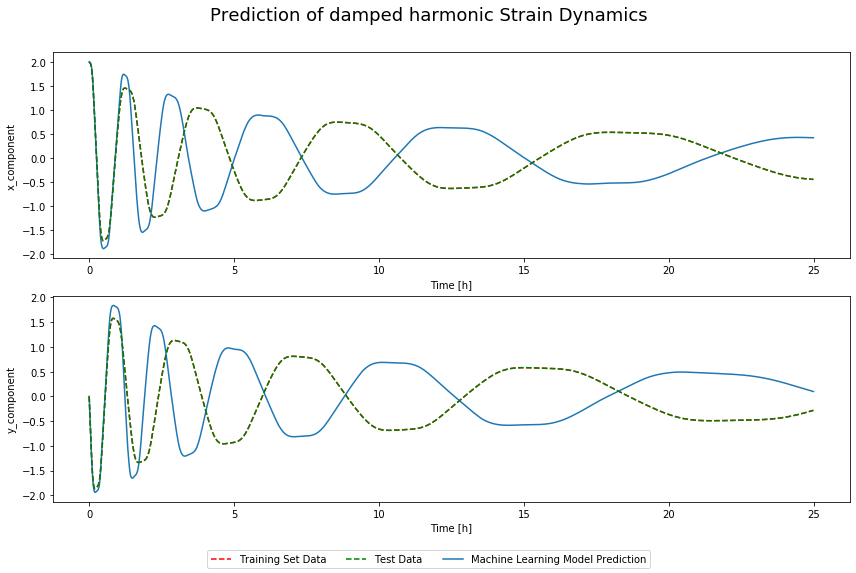

In [8]:
# now we make predictions via numerical integration
# note that in predict_integrate, the function expects a normal dataframe and not the time-series multi-index dataframe
time_points, predictions = predict_onestep.predict_integrate(df, df, rf_dict, target_list, feature_list, title='damped harmonic', plot=True,model_type='random_forest', subplots=(2,1))

# 4. Improving the one-step learning method

There are a few ideas:
* augment more data points
* use more trees
* get more data

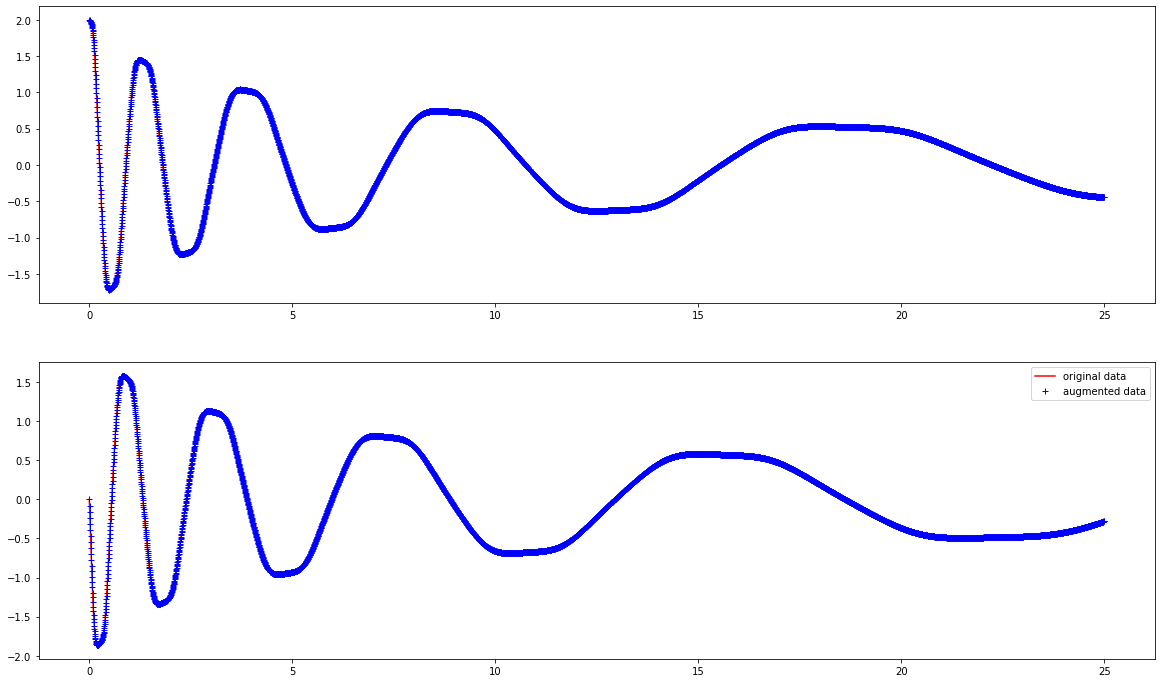

In [7]:
# first lets get more data by simply 
df_train2 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=5000)

# make sure the augmented data corresponds to the original data
plt.figure(figsize = (20, 12))
for species in range(2):
    plt.subplot(2, 1, species + 1)
    plt.plot(time_points, df.iloc[:,species], 'r-', label='original data')
    plt.plot(df_train2.index.get_level_values(1), df_train2[('feature', df.columns[species])], 'b+', label='augmented data')
    
plt.legend()

x_component


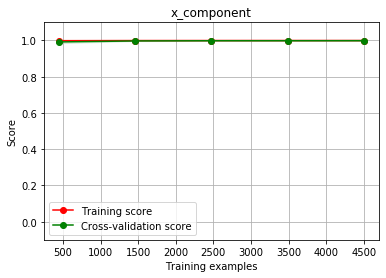

Target: x_component, CV Pearson R2 coefficient: 0.999843
y_component


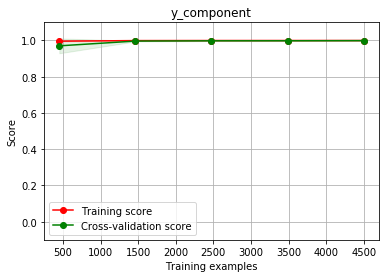

Target: y_component, CV Pearson R2 coefficient: 0.999889
Average training score: 0.9998661903084101


In [8]:
# create a random forest model with 20 estimators
rf_model = RandomForestRegressor(n_estimators=20)
figure_path = './plots/'

# train a model
rf_dict, score_dict = train_onestep.train_classic(df_train2, rf_model, plot=True,model_type='random_forest', figure_path=figure_path)

x_component RMSE: -1.4289537998834025e-05 standard deviation: 0.02230808443335468


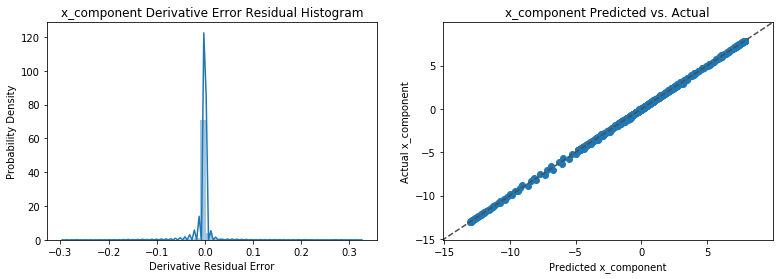

y_component RMSE: -0.0004486961661316501 standard deviation: 0.018933807166732312


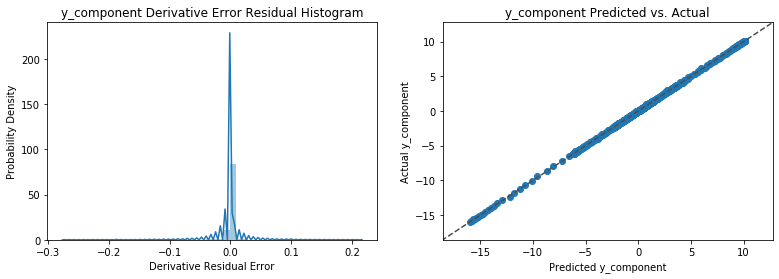

Total Derivative Mean Error: 0.03351195831544953 Error Standard Deviation: 0.062065380825171414


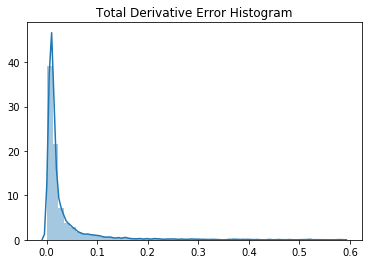

In [9]:
# generate reports on the residual errors

train_onestep.compute_error(df_train2,rf_dict,plot=True,model_type='random_forest')

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.992028,-0.159044
0,1.983873,-0.316164
0,1.974847,-0.471225
0,1.963856,-0.623866
...,...,...
0,-0.441769,-0.288236
0,-0.442157,-0.286486
0,-0.442536,-0.284731


Predicted data:


,x_component,y_component
Time,,
0.00,2.000000,0.000000
0.01,1.992037,-0.158714
0.02,1.983824,-0.315847
0.03,1.975637,-0.471053
0.04,1.967183,-0.623716
...,...,...
24.95,0.419754,0.164842
24.96,0.419590,0.163152
24.97,0.419427,0.161464


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 4.894385607280556 RMSE percentage: 178.8596796144254
ML Fit: y_component 4.981224306614974 RMSE percentage: 164.192448971598
ML model aggregate error
Average RMSE: 4.937804956947765
Total percentage error: 171.5260642930117


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


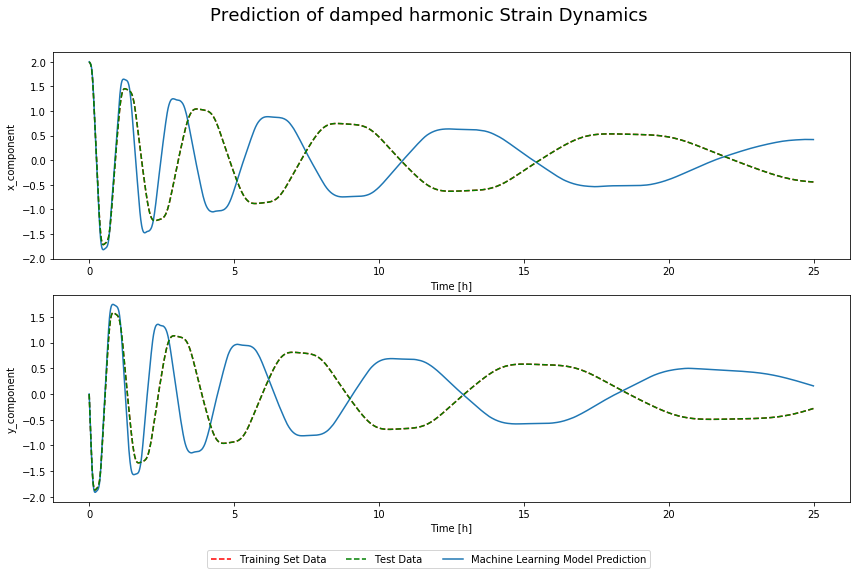

In [10]:
# now we make predictions via numerical integration
# note that in predict_integrate, the function expects a normal dataframe and not the time-series multi-index dataframe
time_points, predictions = predict_onestep.predict_integrate(df, df, rf_dict, target_list, feature_list, title='damped harmonic', plot=True,model_type='random_forest', subplots=(2,1), bio=False)

x_component


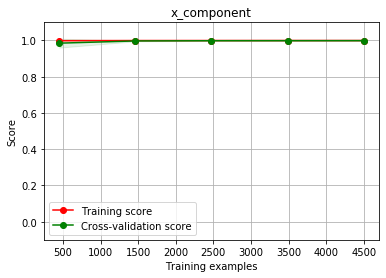

Target: x_component, CV Pearson R2 coefficient: 0.999867
y_component


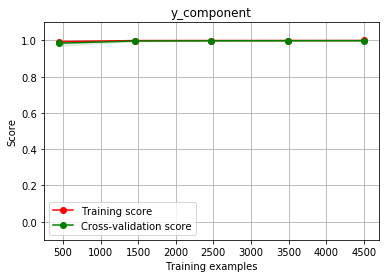

Target: y_component, CV Pearson R2 coefficient: 0.999901
Average training score: 0.9998841114189466


In [11]:
# create a random forest model with 100 estimators
rf_model = RandomForestRegressor(n_estimators=100)
figure_path = './plots/'

# train a model
rf_dict, score_dict = train_onestep.train_classic(df_train2, rf_model, plot=True,model_type='random_forest', figure_path=figure_path)

x_component RMSE: -4.3225962599878856e-05 standard deviation: 0.02050097448915643


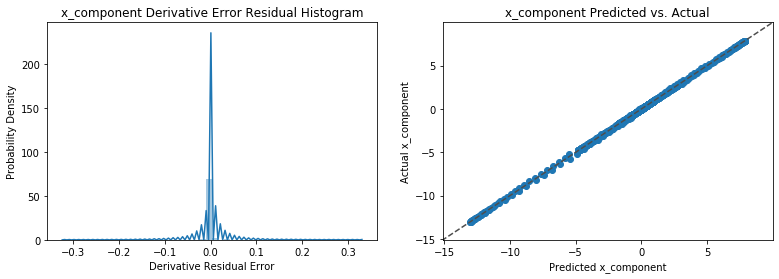

y_component RMSE: -0.0004218111491473543 standard deviation: 0.017928607032247523


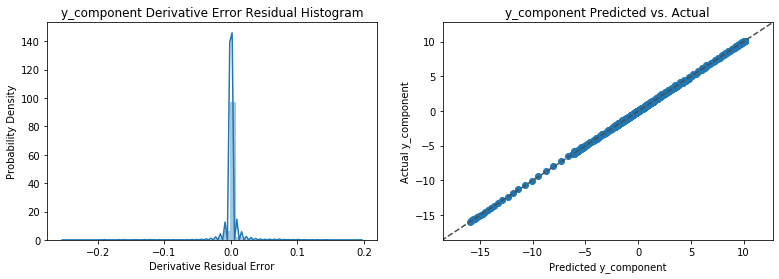

Total Derivative Mean Error: 0.030321147058997883 Error Standard Deviation: 0.06030061233178005


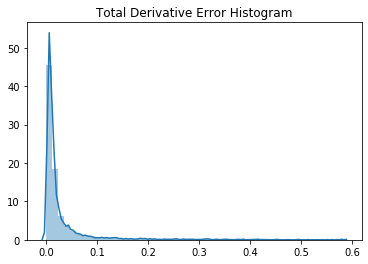

In [12]:
# generate reports on the residual errors

train_onestep.compute_error(df_train2,rf_dict,plot=True,model_type='random_forest')

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.992028,-0.159044
0,1.983873,-0.316164
0,1.974847,-0.471225
0,1.963856,-0.623866
...,...,...
0,-0.441769,-0.288236
0,-0.442157,-0.286486
0,-0.442536,-0.284731


Predicted data:


,x_component,y_component
Time,,
0.00,2.000000,0.000000
0.01,1.992118,-0.158611
0.02,1.983920,-0.315745
0.03,1.975850,-0.470859
0.04,1.966993,-0.623649
...,...,...
24.95,0.420167,0.160580
24.96,0.420029,0.158877
24.97,0.419888,0.157173


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 4.911058369407251 RMSE percentage: 178.73023000074764
ML Fit: y_component 4.994632209550702 RMSE percentage: 178.63783672042416
ML model aggregate error
Average RMSE: 4.952845289478977
Total percentage error: 178.68403336058591


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


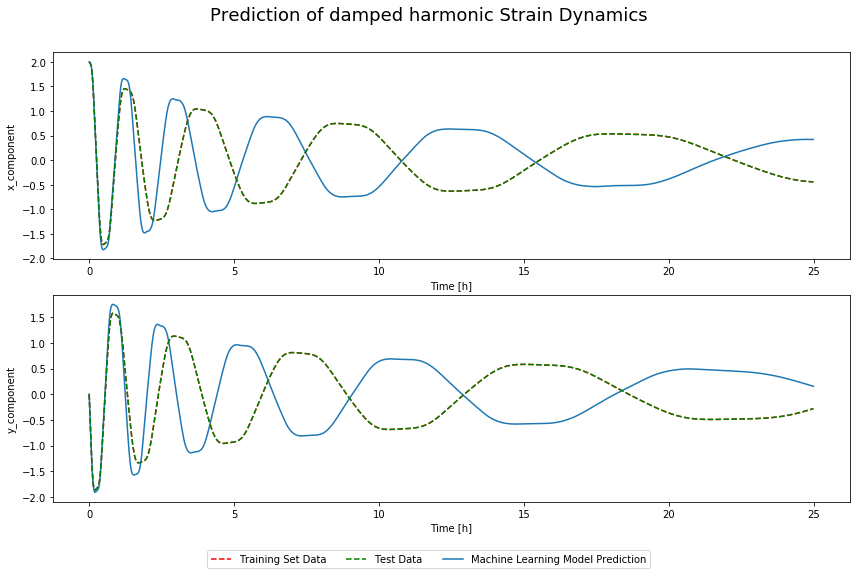

In [13]:
# now we make predictions via numerical integration
# note that in predict_integrate, the function expects a normal dataframe and not the time-series multi-index dataframe
time_points, predictions = predict_onestep.predict_integrate(df, df, rf_dict, target_list, feature_list, title='damped harmonic', plot=True,model_type='random_forest', subplots=(2,1), bio=False)

Text(0.5, 1.0, 'Phase Portrait of the 2-D Harmonic Oscillator')

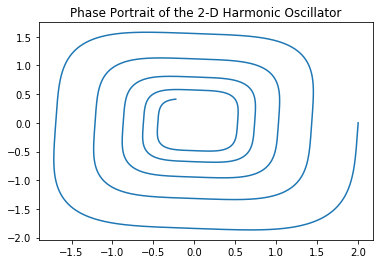

In [2]:
# get more data
time_points, cubic_data = harmonic.simulate_custom(tend=30, step=.001)

# Phase plane plot
plt.plot(cubic_data[0,:,0], cubic_data[0,:,1])
plt.title('Phase Portrait of the 2-D Harmonic Oscillator')

In [3]:
# create a pandas dataframe from the tensors

df = pd.DataFrame(cubic_data.numpy()[0])
df.columns = ['x_component', 'y_component']
df['Strain'] = [0] * df.shape[0]
df = df.set_index('Strain')
df['Time'] = time_points
df.head()

,x_component,y_component,Time
Strain,,,
0,2.000000,0.000000,0.000
0,1.999200,-0.015990,0.001
0,1.998402,-0.031962,0.002
0,1.997604,-0.047914,0.003
0,1.996807,-0.063847,0.004


In [6]:
# now generate and augment the training dataset
print('Original data shape:', df.shape)

feature_list = [] # here we do not have external time-series or control variables
target_list = ['x_component', 'y_component']

df_train = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=30000)
display(df_train)

Original data shape: (30000, 3)


feature      target       feature      target
              x_component x_component   y_component y_component
Strain Time                                                    
0      0.000     2.000000   -0.799302 -2.616573e-08  -15.990890
       0.001     1.999201   -0.798952 -1.599038e-02  -15.981336
       0.002     1.998402   -0.798251 -3.196163e-02  -15.962227
       0.003     1.997604   -0.797466 -4.791377e-02  -15.943108
       0.004     1.996807   -0.796753 -6.384678e-02  -15.924001
...                   ...         ...           ...         ...
       29.995   -0.227758    0.141782  4.127116e-01    0.016600
       29.996   -0.227617    0.141797  4.127281e-01    0.016555
       29.997   -0.227475    0.141812  4.127447e-01    0.016512
       29.998   -0.227333    0.141827  4.127612e-01    0.016468
       29.999   -0.227191    0.141834  4.127776e-01    0.016446

[30000 rows x 4 columns]

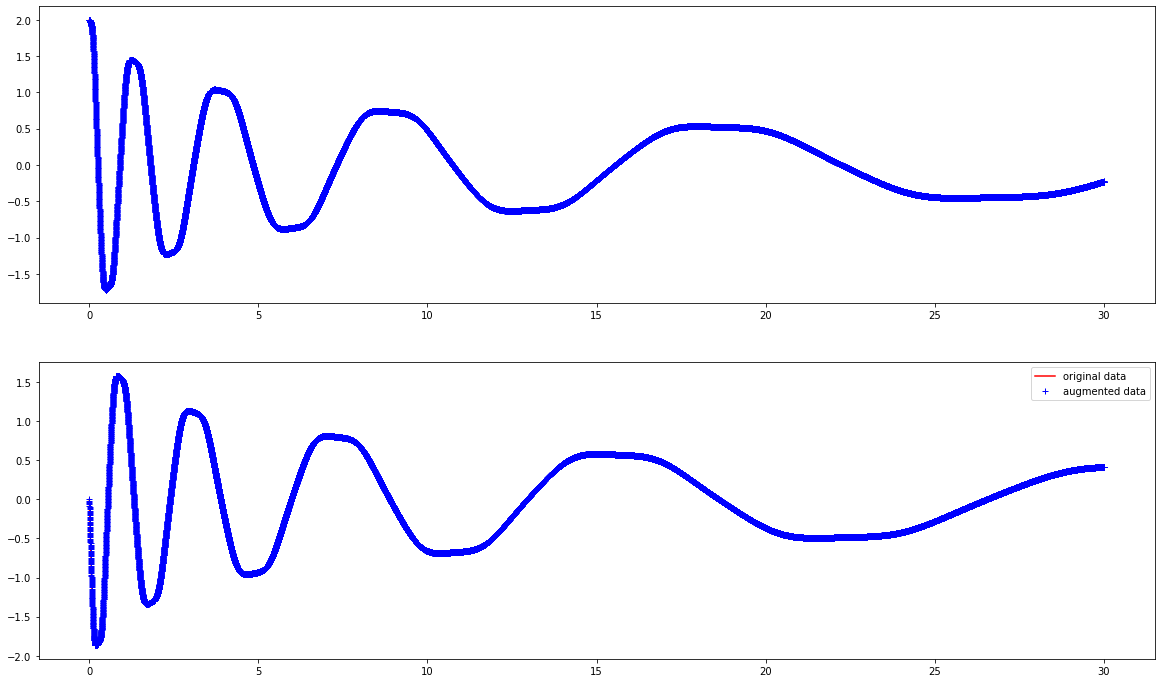

In [7]:
# make sure the augmented data corresponds to the original data
plt.figure(figsize = (20, 12))
for species in range(2):
    plt.subplot(2, 1, species + 1)
    plt.plot(time_points, df.iloc[:,species], 'r-', label='original data')
    plt.plot(time_points, df_train[('feature', df.columns[species])], 'b+', label='augmented data')
    
plt.legend()

x_component


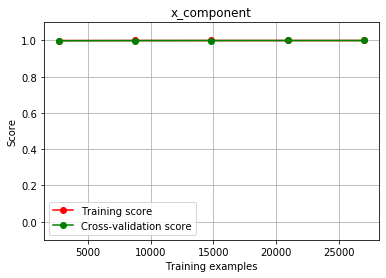

Target: x_component, CV Pearson R2 coefficient: 0.999992
y_component


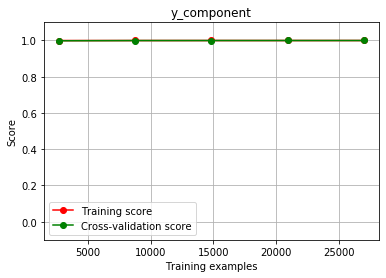

Target: y_component, CV Pearson R2 coefficient: 0.999994
Average training score: 0.9999928026886439


In [8]:
# create a random forest model with 20 estimators
rf_model = RandomForestRegressor(n_estimators=20)
figure_path = './plots/'

# train a model
rf_dict, score_dict = train_onestep.train_classic(df_train, rf_model, plot=True,model_type='random_forest', figure_path=figure_path)

x_component RMSE: 0.00010161625342395063 standard deviation: 0.004616374871960712


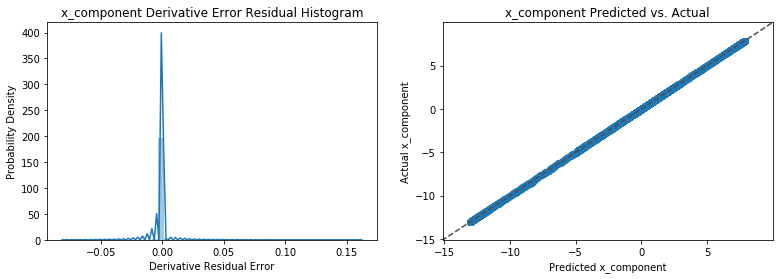

y_component RMSE: -0.00010267112935253306 standard deviation: 0.004126201927436723


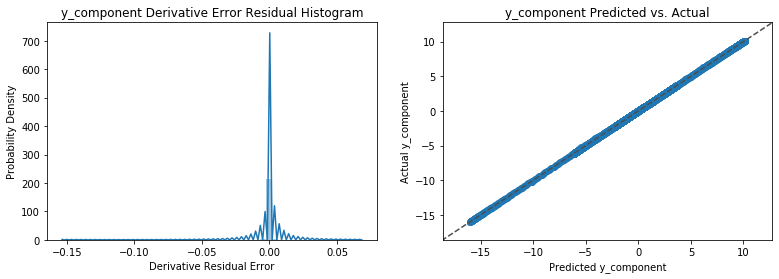

Total Derivative Mean Error: 0.012960066061377779 Error Standard Deviation: 0.0227715463865171


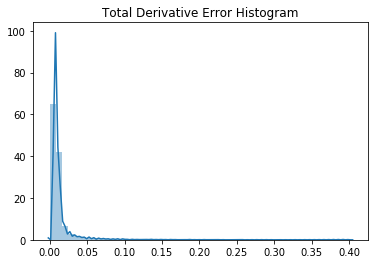

In [9]:
# generate reports on the residual errors

train_onestep.compute_error(df_train,rf_dict,plot=True,model_type='random_forest')

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.999200,-0.015990
0,1.998402,-0.031962
0,1.997604,-0.047914
0,1.996807,-0.063847
...,...,...
0,-0.227758,0.412712
0,-0.227617,0.412728
0,-0.227475,0.412745


Predicted data:


,x_component,y_component
Time,,
0.000,2.000000,0.000000
0.001,1.999201,-0.015978
0.002,1.998402,-0.031947
0.003,1.997604,-0.047899
0.004,1.996807,-0.063830
...,...,...
29.995,-0.232131,0.412686
29.996,-0.231989,0.412703
29.997,-0.231848,0.412721


./source/predict_onestep.py:217: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  

ML Fit: x_component 0.02866552771179022 RMSE percentage: 17.67309507228923
ML Fit: y_component 0.028757990000820903 RMSE percentage: 20.156316698451207
ML model aggregate error
Average RMSE: 0.02871175885630556
Total percentage error: 18.91470588537022


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


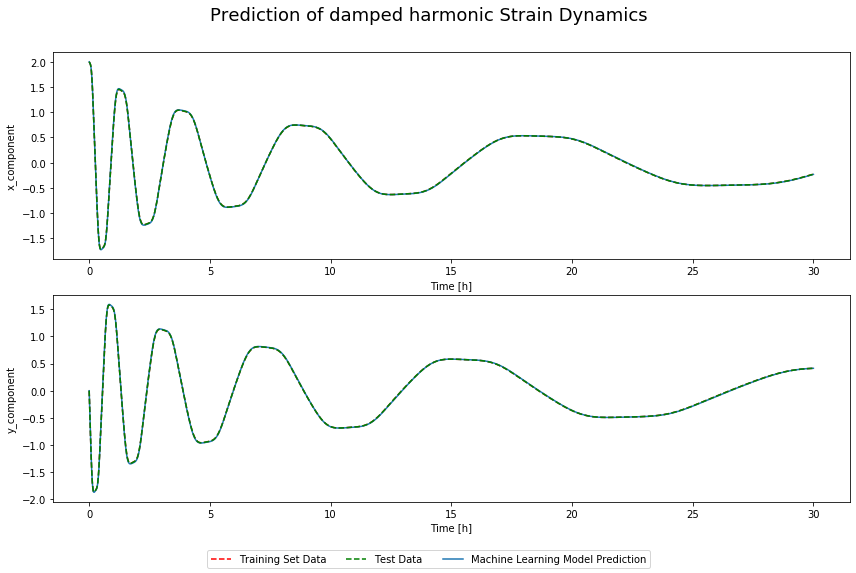

In [10]:
# now we make predictions via numerical integration
# note that in predict_integrate, the function expects a normal dataframe and not the time-series multi-index dataframe
time_points, predictions = predict_onestep.predict_integrate(df, df, rf_dict, target_list, feature_list, title='damped harmonic', plot=True,model_type='random_forest', subplots=(2,1), bio=False)